In [1]:
pip install shapely


Note: you may need to restart the kernel to use updated packages.


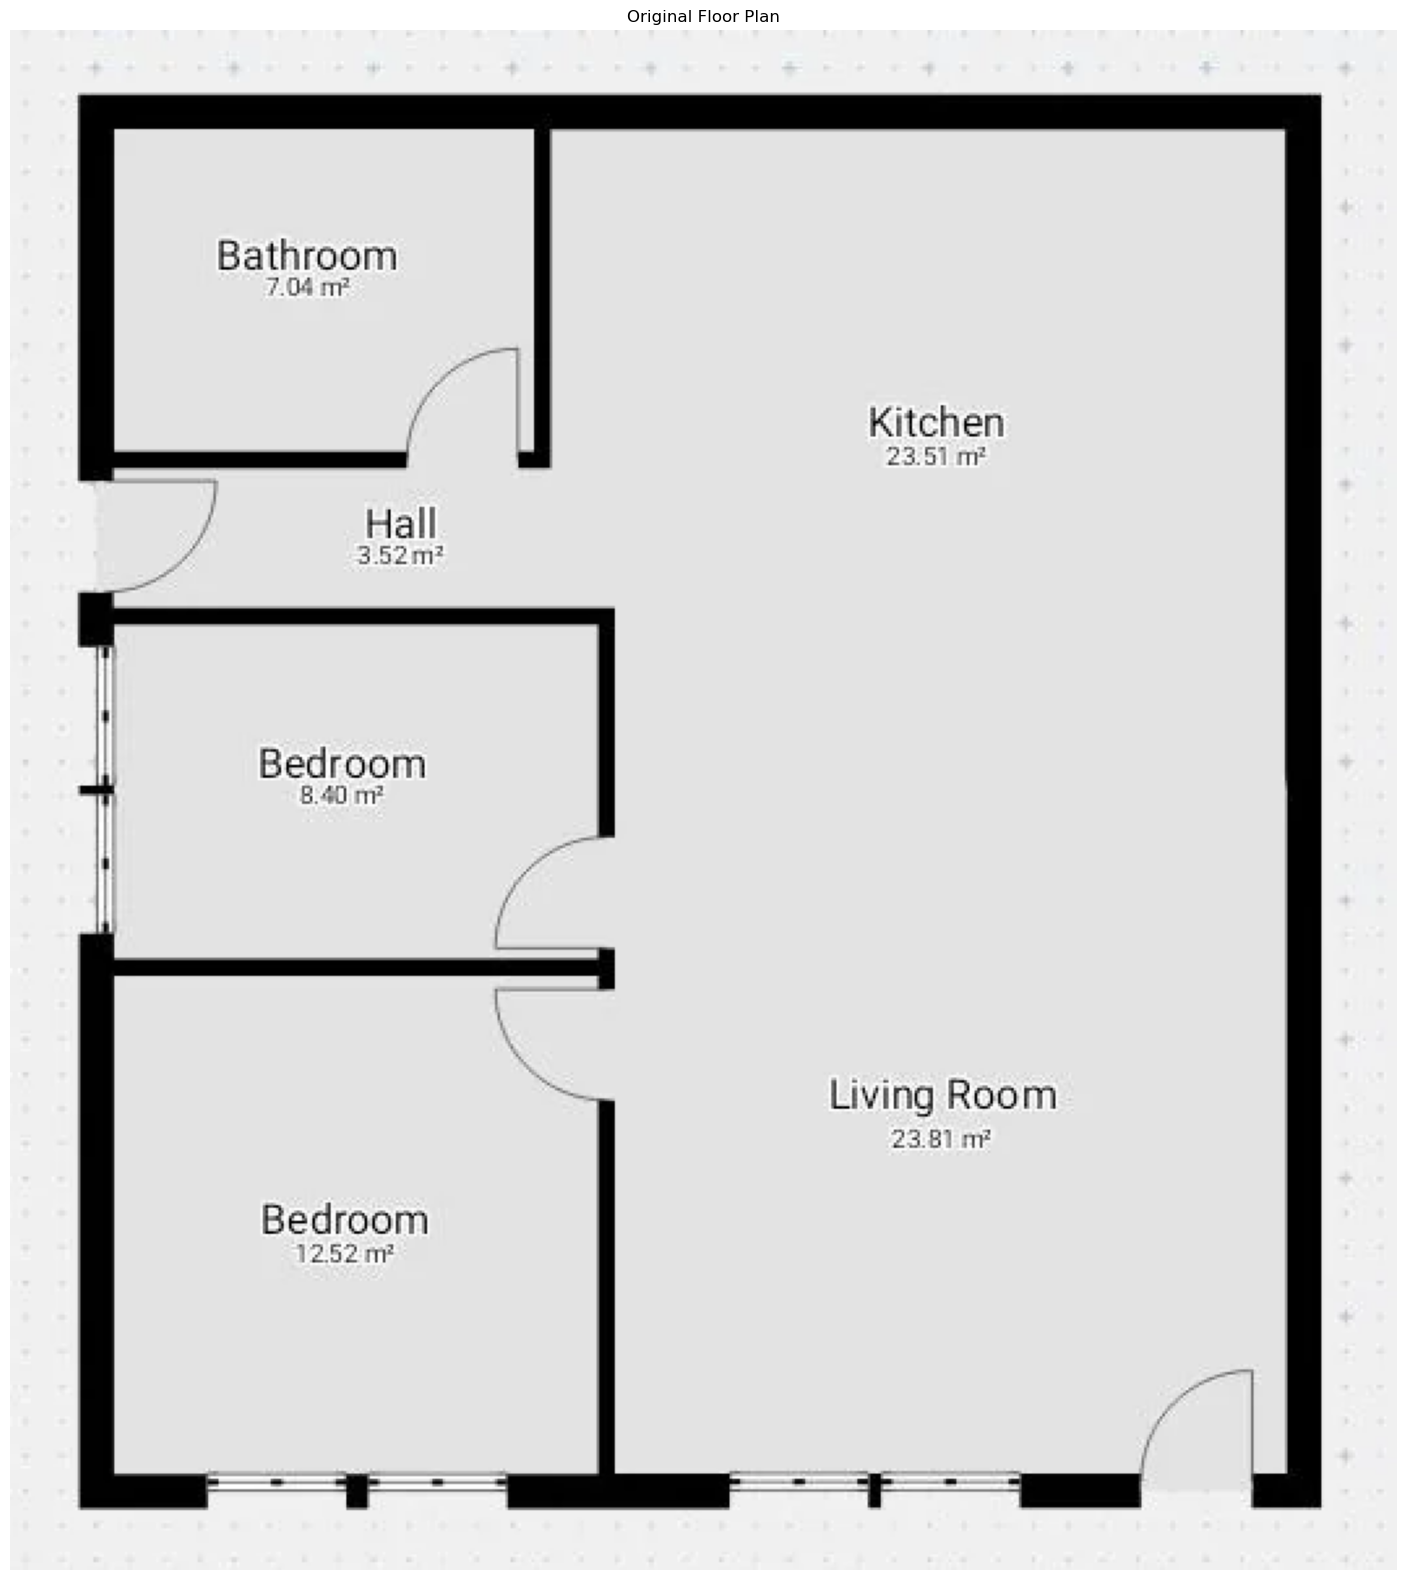

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Load the image
img = cv2.imread("data/simplefloorplan.png")  # adjust path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
plt.title("Original Floor Plan")
plt.axis("off")
plt.show()


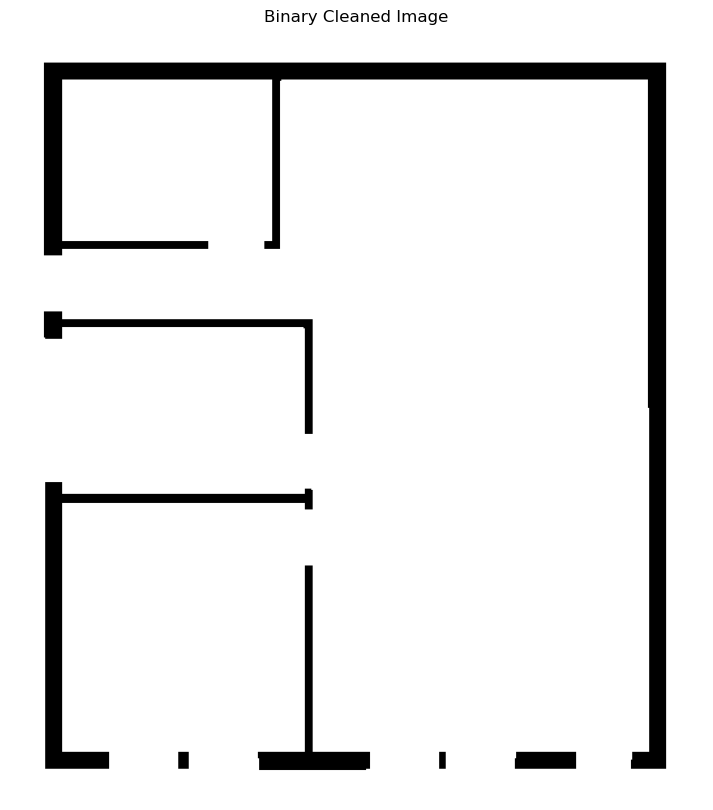

In [22]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Otsu thresholding (auto adaptive)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Ensure walls = white, background = black
# If inverted, use bitwise_not()
if np.mean(bw) < 127:
    bw = cv2.bitwise_not(bw)

# Clean up with morphology
kernel = np.ones((3, 3), np.uint8)

bw_clean = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
bw_clean = cv2.morphologyEx(bw_clean, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.imshow(bw_clean, cmap="gray")
plt.title("Binary Cleaned Image")
plt.axis("off")
plt.show()


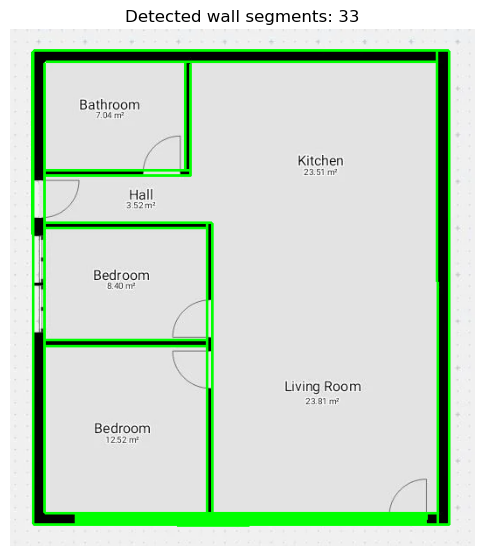

In [23]:
edges = cv2.Canny(bw_clean, 50, 150, apertureSize=3)

# --- Wall detection using Probabilistic Hough Transform ---

lines = cv2.HoughLinesP(
    edges,
    rho=1,                        # distance resolution in pixels
    theta=np.pi/180,              # angle resolution in radians (~1°)
    threshold=5,                 # votes required to form a line
    minLineLength=60,             # minimum wall length (px)
    maxLineGap=150                  # max gap between segments to link them
)

# --- Visualize results ---
wall_vis = img_rgb.copy()

if lines is not None:
    for (x1, y1, x2, y2) in lines[:, 0, :]:
        cv2.line(wall_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(6, 8))
plt.imshow(wall_vis)
plt.title(f"Detected wall segments: {0 if lines is None else len(lines)}")
plt.axis("off")
plt.show()





547.5
48.0
84.0
1810.0
4259.0
1632.5
15475.5


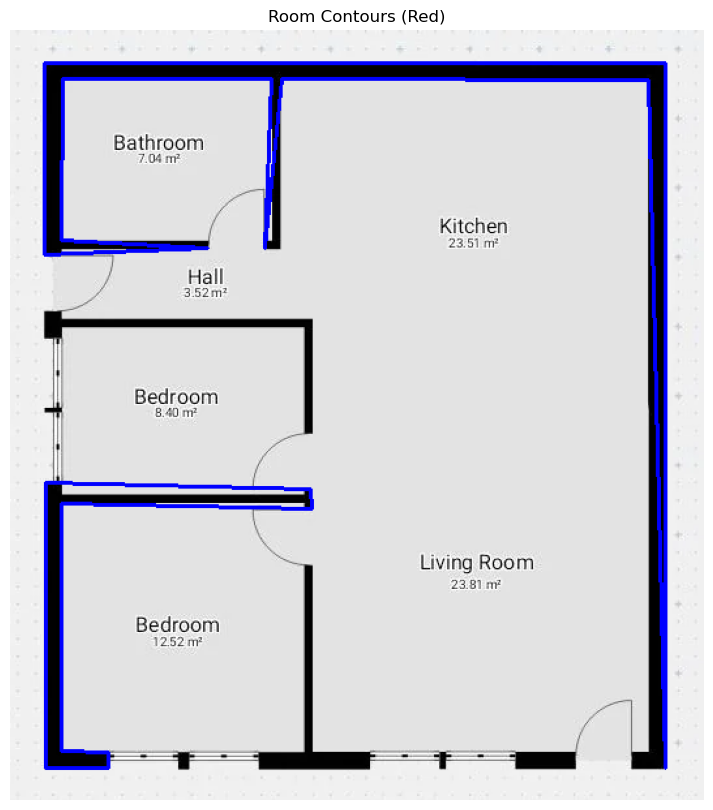

Detected 2 rooms.


In [24]:
# Invert image so rooms = white
inv = cv2.bitwise_not(bw_clean)

contours, hierarchy = cv2.findContours(inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

room_vis = img_rgb.copy()
rooms = []

for c in contours:
    area = cv2.contourArea(c)
    print(area)
    if area < 2000:   # ignore small specks
        continue
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * perimeter, True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.drawContours(room_vis, [approx], -1, (0,0,255), 2)
    rooms.append({
        "area": float(area),
        "bbox": [int(x), int(y), int(w), int(h)],
        "polygon": approx.squeeze().tolist()
    })

plt.figure(figsize=(10,10))
plt.imshow(room_vis)
plt.title("Room Contours (Red)")
plt.axis("off")
plt.show()

print(f"Detected {len(rooms)} rooms.")


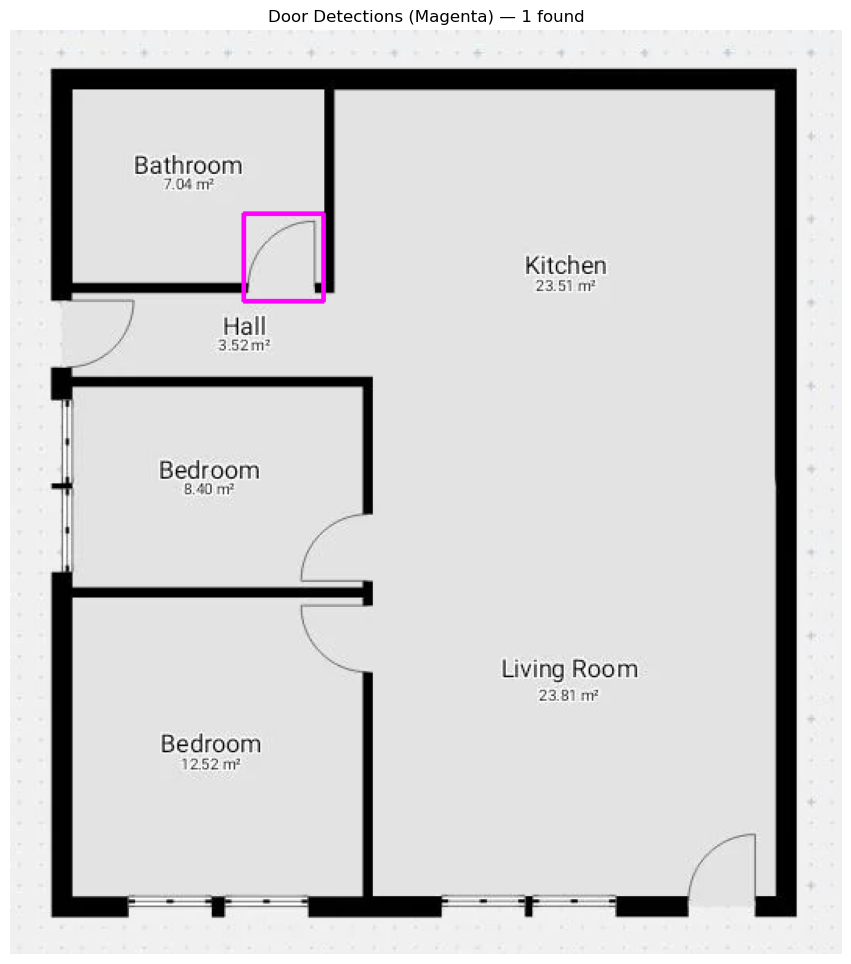

In [26]:
# --- Step 1: Read images ---
plan_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
door_t = cv2.imread("data/door_temp.png", cv2.IMREAD_GRAYSCALE)

# --- Step 2: Multi-scale, multi-orientation matching ---
scales = [0.5, 0.75, 1.0, 1.25]
rotations = [0, 90, 180, 270]
threshold = .85  # matching confidence

door_vis = img_rgb.copy()
all_matches = []

for angle in rotations:
    # rotate template
    (h, w) = door_t.shape[:2]
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(door_t, rot_mat, (w, h), flags=cv2.INTER_LINEAR)

    for s in scales:
        temp = cv2.resize(rotated, None, fx=s, fy=s)
        res = cv2.matchTemplate(plan_gray, temp, cv2.TM_CCOEFF_NORMED)
        yy, xx = np.where(res >= threshold)

        h2, w2 = temp.shape[:2]
        for (x, y) in zip(xx, yy):
            all_matches.append((x, y, w2, h2))

# --- Step 3: Draw detections ---
for (x, y, w, h) in all_matches:
    cv2.rectangle(door_vis, (x, y), (x + w, y + h), (255, 0, 255), 2)

plt.figure(figsize=(12, 12))
plt.imshow(door_vis)
plt.title(f"Door Detections (Magenta) — {len(all_matches)} found")
plt.axis("off")
plt.show()
